# Inference with missing values

Our task will be to estimate means despite of missing values with four approaches:
* Complete-case analysis
* Single imputation
* Inverse Probability Weighting (IPW)
* Augmented Inverse Probability Weighting (AIPW)

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns

Load functions for generating data, plots, ...

In [2]:
from inference_utils import generate_X, generate_MCAR_missingness, generate_MAR_missingness, generate_MNAR_missingness, plot_X, plot_x1

In [3]:
# Define some constants
# analysis will be repeated n_datasets times to capture sampling variance.
n_datasets = 30
n_samples = 1000
missing_rate = 0.5
methods = ['cc', 'si', 'ipw', 'aipw']

In [4]:
# Generate data
X_complete = generate_X(n_samples=100, seed=0)

In [5]:
# Generate missing values
X = generate_MCAR_missingness(X_complete, missing_rate, 0)

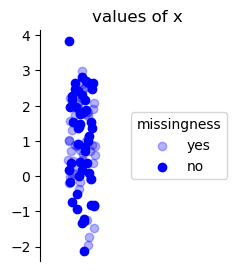

In [6]:
# Plot the values of the first variable in X.
x1 = X_complete[:, 0]
m1 = np.isnan(X[:, 0])
plot_x1(x1, m1)

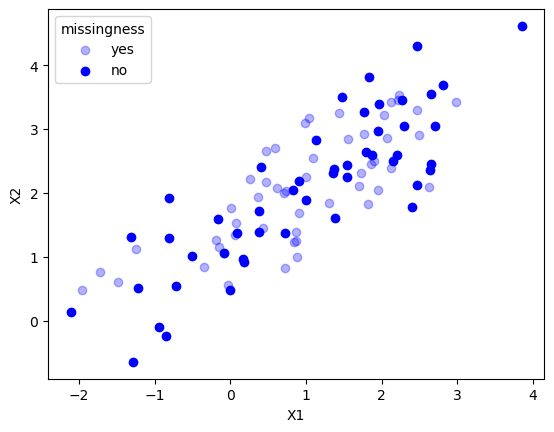

In [7]:
# Plot the 2-dimensional data
plot_X(X_complete, m1)

### 1 - Complete-case estimator

Complete the function below to return a mean estimated using the complete-case estimator.

In [8]:
def complete_case_estimator(x):
    """Returns the mean of a vector with missing values, using complete-case
    analysis.

    Parameters
    ----------
    x: array-like of shape (n_samples, )
        A vector with missing values.
    """
    # ------------TO DO ------------
    mean_cc = np.nanmean(x)
    return mean_cc

    # Other option
    # ind = np.isnan(x)
    # return np.mean(x[~ind])

Check that the complete-case estimator outputs a reasonable estimate.

In [9]:
x1 = X[:, 0]
mean_cc = complete_case_estimator(x1)
print(f"Complete-case estimation: {mean_cc}")

Complete-case estimation: 0.9960771125004767


### 2 - Single-imputation estimator

Complete the function below to return a mean estimated using single imputation.

In [11]:
def single_imputation_estimator(x):
    """Returns the mean of a vector with missing values, using single
    imputation by the mean for inference.

    Parameters
    ----------
    x: array-like of shape (n_samples, )
        A vector with missing values.
    """
    # ------------TO DO ------------
    # Hint: use skearn's SimpleImputer
    imputer = SimpleImputer(strategy='mean')
    x = x[:, None]
    imputer.fit(x)
    x_hat = imputer.transform(x)
    return np.mean(x_hat)

Check that the single-imputation estimator outputs a reasonable estimate.

In [12]:
x1 = X[:, 0]
mean_si = single_imputation_estimator(x1)
print(f"Single-Imputation estimation: {mean_si}")

Single-Imputation estimation: 0.9960771125004766


### 3 - Inverse Probability Weighting (IPW)

Complete the function below to return a mean estimated using IPW.

In [13]:
def ipw_estimator(X):
    """Returns the mean of a vector with missing values, using inverse
    probability weighting.

    Parameters
    ----------
    X: array-like of shape (n_samples, 2)
        Data with missing values only in the first column.
    """
    # ------------TO DO ------------
    # Hint: use skearn's LogisticRegression to learn te probability

    # Variable with missing values
    x = X[:, 0]
    m = ~np.isnan(x)
    # Complete variable
    v = X[:, 1].reshape(-1, 1)
    # Learn the missingness mechanism using logistic regression
    log_reg = LogisticRegression()
    log_reg.fit(v, m)
    probas = log_reg.predict_proba(v)[:, 1]
    # compute the IPW
    x_zeros = np.nan_to_num(x)
    mean_ipw = np.mean(x_zeros/probas)
    return mean_ipw

Check that the IPW estimator outputs a reasonable estimate.

In [14]:
mean_ipw = ipw_estimator(X)
print(f"IPW estimation: {mean_ipw}")

IPW estimation: 0.99723884713481


### 4 - Augmented Inverse Probability Weighting (AIPW)

Complete the function below to return a mean estimated using AIPW.

In [15]:
def aipw_estimator(X):
    """Returns the mean of a vector with missing values, using inverse
    probability weighting.

    Parameters
    ----------
    X: array-like of shape (n_samples, 2)
        Data with missing values only in the first column.
    """
    # ------------TO DO ------------
    # Hint: use skearn's LogisticRegression to learn te probability
    # and skearn's LinearRegression to predict outcomes.

    # Variable with missing values
    x = X[:, 0]
    m = ~np.isnan(x)
    # Complete variable
    v = X[:, 1].reshape(-1, 1)
    # Learn the missingness mechanism using logistic regression
    log_reg = LogisticRegression()
    log_reg.fit(v, m)
    probas = log_reg.predict_proba(v)[:, 1]
    # predict the observed outcomes using the complete variable
    x_obs = x[m == 1]
    v_obs = v[m == 1]
    lin_reg = LinearRegression()
    lin_reg.fit(v_obs, x_obs)
    pred = lin_reg.predict(v)
    x_zeros = np.nan_to_num(x)
    mean_aipw = np.mean(x_zeros/probas - (m - probas)/probas*pred)
    return mean_aipw

Check that the AIPW estimator outputs a reasonable estimate.

In [16]:
mean_aipw = aipw_estimator(X)
print(f"AIPW estimation: {mean_aipw}")

AIPW estimation: 0.9969972681782237


### 5 - Compare estimators

we will now compare the four estimators under the 3 missing data mechanisms.

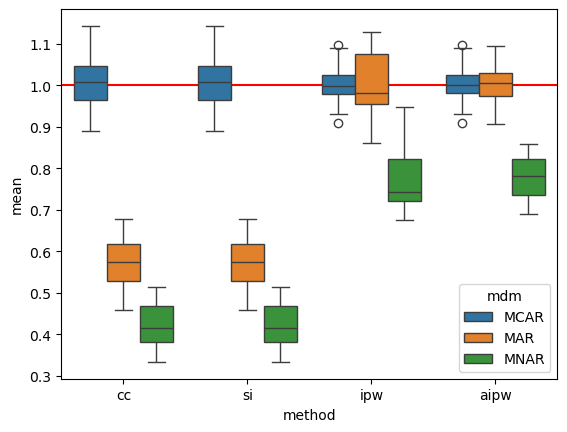

In [17]:
# Perform inference using the various methods defined above on many
# simulated datasets with different missing data mechanisms, and plot the
# results.
perfs = []
for i in range(20):
    for mdm in ['MCAR', 'MAR', 'MNAR']:
        for method in methods:
            # Generate data
            X_complete = generate_X(n_samples, i)

            # Generate missingness
            if mdm == 'MCAR':
                X = generate_MCAR_missingness(X_complete, missing_rate, i)
            elif mdm == 'MAR':
                X = generate_MAR_missingness(X_complete, i)
            elif mdm == 'MNAR':
                X = generate_MNAR_missingness(X_complete, i)
            x = X[:, 0]

            # Inference
            if method == 'cc':
                mean = complete_case_estimator(x)
            elif method == 'si':
                mean = single_imputation_estimator(x)
            elif method == 'ipw':
                mean = ipw_estimator(X)
            elif method == 'aipw':
                mean = aipw_estimator(X)
            perf_item = {'iter': i, 'mdm': mdm, 'method': method,
                         'mean': mean}
            perfs.append(perf_item)

df = pd.DataFrame(perfs)
plt.axhline(y=1, color='r', linestyle='-', zorder=0)
sns.boxplot(data=df, y='mean', x='method', hue='mdm')
plt.show()

Verify that the results you obtain are coherent with what you should obtain for the different missing data mechanisms.